In [146]:
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [2]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data('2000-01-01', '2019-12-31')

In [185]:
quarter_start_month = [1, 4, 7, 10]
days = []
year = 2002
for i in range(60):
    month = quarter_start_month[i % 4]
    start_date = datetime(year, month, 1)
    
    if month == 10:
        year += 1
    
    month = quarter_start_month[(i + 1) % 4]
    end_date = datetime(year, month, 1) - timedelta(days=1)
    
    day = {'start_date':start_date, 'end_date':end_date}
    days.append(day)

In [186]:
df_account = pd.DataFrame(columns=['start_date', 'end_date'])

In [187]:
df_account = df_account.append(days)

In [188]:
df_account

,start_date,end_date
0,2002-01-01,2002-03-31
1,2002-04-01,2002-06-30
2,2002-07-01,2002-09-30
3,2002-10-01,2002-12-31
4,2003-01-01,2003-03-31
5,2003-04-01,2003-06-30
6,2003-07-01,2003-09-30
7,2003-10-01,2003-12-31
8,2004-01-01,2004-03-31
9,2004-04-01,2004-06-30


In [189]:
def get_stocks(start_date):
    print(start_date)
    year_start_date = start_date - timedelta(days=365)
    year_end_date = start_date - timedelta(days=30)
    df_year_price = df_price[(df_price.index > year_start_date) & (df_price.index <= year_end_date)].reset_index()
    
    df_year_price['plus'] = df_year_price['Close'] > df_year_price['Open']
    df_year_price['minus'] = df_year_price['Close'] < df_year_price['Open']
    df_year_price['equal'] = df_year_price['Close'] == df_year_price['Open']
    
    # 종목별로 과거 수익률 구하기 (마지막 1달은 제외)
    df_stock_yield = df_year_price.groupby("Code").agg({'Open': 'first', 
                                                        'Close': 'last', 
                                                        'plus': 'sum',
                                                        'minus': 'sum',
                                                        'equal': 'sum',
                                                        'Date': 'last', 
                                                        'Marcap': 'last'}).reset_index()
    
    df_stock_yield['diff'] = df_stock_yield.apply(lambda x: (year_end_date - x['Date']).days, axis=1)
    df_stock_yield = df_stock_yield[df_stock_yield['diff'] < 7]
    
    # open 가격이 0인 것 제외
    df_stock_yield = df_stock_yield[df_stock_yield['Open'] > 0]
    
    # 시총 하위 50%만 필터링
    df_stock_yield = df_stock_yield.sort_values(by=['Marcap'])
    df_stock_yield = df_stock_yield[:int(len(df_stock_yield)*0.5)]
    
    df_stock_yield['yield'] = df_stock_yield['Close'] / df_stock_yield['Open']
    
    # 수익률이 +인 것만 필터링
    df_stock_yield = df_stock_yield[df_stock_yield['yield'] > 1.0]
    
    # ID 구하기
    df_stock_yield['all'] = df_stock_yield['plus'] + df_stock_yield['minus'] + df_stock_yield['equal']
    df_stock_yield['plus_rate'] = df_stock_yield['plus'] / df_stock_yield['all']
    df_stock_yield['minus_rate'] = df_stock_yield['minus'] / df_stock_yield['all']
    df_stock_yield['id'] = df_stock_yield['minus_rate'] - df_stock_yield['plus_rate']
    
    df_stock_yield['RANK_1'] = df_stock_yield['yield'].rank(ascending=False) # 높을 수록 좋음
    df_stock_yield['RANK_2'] = df_stock_yield['id'].rank(ascending=True) # 낮을수록 좋음
    df_stock_yield['TOTAL_RANK'] = df_stock_yield['RANK_1'] + df_stock_yield['RANK_2']
    
    df_stock_yield = df_stock_yield.sort_values(by=['TOTAL_RANK'], ascending=False)
    
    #df_stock_yield = df_stock_yield.sort_values(by=['yield'], ascending=True)
    #print(df_stock_yield[:30])
    
    return df_stock_yield['Code'].tolist()[:50]

In [190]:
# 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.start_date), axis=1)

2002-01-01 00:00:00
2002-04-01 00:00:00
2002-07-01 00:00:00
2002-10-01 00:00:00
2003-01-01 00:00:00
2003-04-01 00:00:00
2003-07-01 00:00:00
2003-10-01 00:00:00
2004-01-01 00:00:00
2004-04-01 00:00:00
2004-07-01 00:00:00
2004-10-01 00:00:00
2005-01-01 00:00:00
2005-04-01 00:00:00
2005-07-01 00:00:00
2005-10-01 00:00:00
2006-01-01 00:00:00
2006-04-01 00:00:00
2006-07-01 00:00:00
2006-10-01 00:00:00
2007-01-01 00:00:00
2007-04-01 00:00:00
2007-07-01 00:00:00
2007-10-01 00:00:00
2008-01-01 00:00:00
2008-04-01 00:00:00
2008-07-01 00:00:00
2008-10-01 00:00:00
2009-01-01 00:00:00
2009-04-01 00:00:00
2009-07-01 00:00:00
2009-10-01 00:00:00
2010-01-01 00:00:00
2010-04-01 00:00:00
2010-07-01 00:00:00
2010-10-01 00:00:00
2011-01-01 00:00:00
2011-04-01 00:00:00
2011-07-01 00:00:00
2011-10-01 00:00:00
2012-01-01 00:00:00
2012-04-01 00:00:00
2012-07-01 00:00:00
2012-10-01 00:00:00
2013-01-01 00:00:00
2013-04-01 00:00:00
2013-07-01 00:00:00
2013-10-01 00:00:00
2014-01-01 00:00:00
2014-04-01 00:00:00


In [191]:
df_account['yield'] = 0.0
df_account['delisted'] = 0.0
for i, row in df_account.iterrows():
    start_date = df_account.iloc[i].start_date
    end_date = df_account.iloc[i].end_date
    df_year_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]
    
    stocks = row['stocks']
    yields = []
    
    delisted_stocks = 0
    for stock in stocks:
        df_stock_price = df_year_price[df_year_price['Code'] == stock].reset_index()
        
        # 시작 날짜부터 가격이 없는 것. 포트폴리오 편입 불가
        if len(df_stock_price) == 0:
            continue
        
        # 상페 
        last_day = (end_date - df_stock_price.iloc[len(df_stock_price) - 1]['Date']).days
        if last_day > 7:
            yields.append(0.0)
            delisted_stocks += 1
            continue
            
        start_price = df_stock_price.iloc[0]['Open']
        end_price = df_stock_price.iloc[len(df_stock_price) - 1]['Close']

        yields.append(end_price / start_price)
        
        if len(yields) == 30:
            break
    
    yearly_yield = statistics.mean(yields) * 0.99 # 수수료 1%
    df_account.at[i, 'yield'] = yearly_yield
    df_account.at[i, 'delisted'] = delisted_stocks
    print(start_date, end_date, yearly_yield)

2002-01-01 00:00:00 2002-03-31 00:00:00 1.1411561743866445
2002-04-01 00:00:00 2002-06-30 00:00:00 0.8105570327559414
2002-07-01 00:00:00 2002-09-30 00:00:00 0.9594613826489479
2002-10-01 00:00:00 2002-12-31 00:00:00 0.9902924399125049
2003-01-01 00:00:00 2003-03-31 00:00:00 0.8818430909429819
2003-04-01 00:00:00 2003-06-30 00:00:00 1.0569494815891767
2003-07-01 00:00:00 2003-09-30 00:00:00 0.9218469629224629
2003-10-01 00:00:00 2003-12-31 00:00:00 1.1842062390600394
2004-01-01 00:00:00 2004-03-31 00:00:00 0.9263079923307774
2004-04-01 00:00:00 2004-06-30 00:00:00 0.9502496519736456
2004-07-01 00:00:00 2004-09-30 00:00:00 0.957959573283228
2004-10-01 00:00:00 2004-12-31 00:00:00 0.9540723533046055
2005-01-01 00:00:00 2005-03-31 00:00:00 1.1566938278674381
2005-04-01 00:00:00 2005-06-30 00:00:00 1.135875907886387
2005-07-01 00:00:00 2005-09-30 00:00:00 1.2711505563084897
2005-10-01 00:00:00 2005-12-31 00:00:00 1.489285503297116
2006-01-01 00:00:00 2006-03-31 00:00:00 0.93586150140858
20

In [192]:
df_account['cum_yield'] = df_account['yield'].cumprod()

In [193]:
df_account

,start_date,end_date,stocks,yield,delisted,cum_yield
0,2002-01-01,2002-03-31,"[007050, 000225, 033040, 054150, 004410, 01178...",1.141156,0.0,1.141156
1,2002-04-01,2002-06-30,"[053260, 002720, 006090, 008400, 012410, 03151...",0.810557,0.0,0.924972
2,2002-07-01,2002-09-30,"[001340, 006090, 004530, 032685, 007190, 00142...",0.959461,0.0,0.887475
3,2002-10-01,2002-12-31,"[012400, 007910, 032960, 045520, 011300, 01458...",0.990292,0.0,0.878860
4,2003-01-01,2003-03-31,"[003780, 041590, 007110, 033640, 008250, 02315...",0.881843,0.0,0.775016
5,2003-04-01,2003-06-30,"[005110, 002360, 009415, 007110, 004985, 00402...",1.056949,2.0,0.819153
6,2003-07-01,2003-09-30,"[052670, 039060, 036580, 008370, 001975, 04552...",0.921847,0.0,0.755134
7,2003-10-01,2003-12-31,"[037500, 009380, 052670, 023890, 001570, 00455...",1.184206,0.0,0.894234
8,2004-01-01,2004-03-31,"[035830, 001570, 037500, 060380, 037700, 03401...",0.926308,1.0,0.828336
9,2004-04-01,2004-06-30,"[023600, 024830, 034600, 036660, 011050, 01957...",0.950250,1.0,0.787126


In [197]:
pow(df_account.iloc[len(df_account) - 1]['cum_yield'], 1 / ( (3 * len(df_account)) / 12))

1.1823365698177581

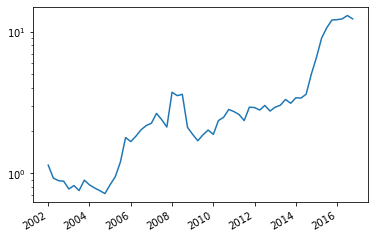

In [198]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot_date(df_account['start_date'], df_account['cum_yield'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [199]:
statistics.stdev(df_account['yield'])

0.17548634081419542